## DIVERS demo
### overview
this is a quick guide demonstrating simple analysis of results generated by DIVERS. we will analyze fecal samples spike-in sequencing data (Fig. 1-3 in the manuscript).

### load libraries
load the utility functions as well as a few python libraries for analysis, visualization, etc.

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Plotting is done using matplotlib.pyplot
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline

### set data directory
set the directory from which the input files will be drawn from, including the prefix of DIVERS results and the taxonomy annotation of these OTUs

In [2]:
DIVERS_output_prefix = "./test_output/test.variance_3"
taxonomy_annotation_path = "./test_data/test.taxonomy.tsv"

### load taxonomy annotation

In [3]:
def removeQuote(string):
    if string[0] == "\"":
        return string[1:-1]
    else:
        return string
    
with open(taxonomy_annotation_path) as f:
    data_taxonomy = pd.read_table(f, sep = '\t', lineterminator = '\n')
taxonomy_Pool = []
for i in range(data_taxonomy.shape[0]):
    tmpList = data_taxonomy["taxonomy"][i].split("; ")
    if len(tmpList) == 14:
        tmpOut = [removeQuote(tmpList[4]), removeQuote(tmpList[6]), removeQuote(tmpList[8]), removeQuote(tmpList[10]), removeQuote(tmpList[12])]
    elif len(tmpList) == 16:
        tmpOut = [removeQuote(tmpList[4]), removeQuote(tmpList[6]), removeQuote(tmpList[10]), removeQuote(tmpList[12]), removeQuote(tmpList[14])]
    elif len(tmpList) == 18:
        tmpOut = [removeQuote(tmpList[4]), removeQuote(tmpList[6]), removeQuote(tmpList[10]), removeQuote(tmpList[14]), removeQuote(tmpList[16])]
    else:
        tmpOut = ["",] * 5
    taxonomy_Pool.append([data_taxonomy["OTU"][i],] + tmpOut)
df_taxonomy = pd.DataFrame(taxonomy_Pool)
df_taxonomy.columns = ["OTU","phlum","class","order","family","genus"]
df_taxonomy.head()

,OTU,phlum,class,order,family,genus
0,otu_1,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia
1,otu_2,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia
2,otu_3,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia
3,otu_4,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia
4,otu_5,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Faecalibacterium


### load variance decompostion result

In [4]:
with open(DIVERS_output_prefix + ".variance_decomposition.tsv") as f:
    data_variance_decomposition = pd.read_table(f, sep = '\t', lineterminator = '\n')

data_variance_decomposition.head()

,OTU_ID,Average_abundances,Total_variances,Temporal_variances,Spatial_variances,Technical_variances
0,otu_1,0.145602,0.007761,0.005929,0.000978,0.000874
1,otu_2,0.097879,0.001755,0.001184,0.000501,0.000204
2,otu_3,0.058864,0.000361,0.000212,0.000025,0.000076
3,otu_4,0.040431,0.000490,0.000343,0.000083,0.000026
4,otu_5,0.091201,0.005708,0.004867,0.000000,0.000153


### bin OTUs according to average OTU abundance
we will bin OTUs according to their average abundance aross different samples and calculate decomposed variances for each bin

In [5]:
b_w = 1
bins = [i for i in range(-7, -1, b_w)]
means_var_fraction_T = []
means_var_fraction_S = []
means_var_fraction_N = []
sem_var_fraction_T = []
sem_var_fraction_S = []
sem_var_fraction_N = []
for i in range(len(bins)):
    if i < len(bins) - 1:
        tmpDF = data_variance_decomposition[(data_variance_decomposition["Average_abundances"] > 10 ** bins[i]) &
                                            (data_variance_decomposition["Average_abundances"] <= 10 ** bins[i + 1])]
    else:
        tmpDF = data_variance_decomposition[(data_variance_decomposition["Average_abundances"] > 10 ** bins[i])]

    means_var_fraction_T.append(np.nanmean(tmpDF["Temporal_variances"] / (tmpDF["Temporal_variances"] + tmpDF["Spatial_variances"] + tmpDF["Technical_variances"])))
    means_var_fraction_S.append(np.nanmean(tmpDF["Spatial_variances"] / (tmpDF["Temporal_variances"] + tmpDF["Spatial_variances"] + tmpDF["Technical_variances"])))
    means_var_fraction_N.append(np.nanmean(tmpDF["Technical_variances"] / (tmpDF["Temporal_variances"] + tmpDF["Spatial_variances"] + tmpDF["Technical_variances"])))
    sem_var_fraction_T.append(np.nanstd(tmpDF["Temporal_variances"] / (tmpDF["Temporal_variances"] + tmpDF["Spatial_variances"] + tmpDF["Technical_variances"])) / np.sqrt(tmpDF.shape[0]))
    sem_var_fraction_S.append(np.nanstd(tmpDF["Spatial_variances"] / (tmpDF["Temporal_variances"] + tmpDF["Spatial_variances"] + tmpDF["Technical_variances"])) / np.sqrt(tmpDF.shape[0]))
    sem_var_fraction_N.append(np.nanstd(tmpDF["Technical_variances"] / (tmpDF["Temporal_variances"] + tmpDF["Spatial_variances"] + tmpDF["Technical_variances"])) / np.sqrt(tmpDF.shape[0]))

array_means_var_fraction_T = np.array(means_var_fraction_T)
array_means_var_fraction_S = np.array(means_var_fraction_S)
array_means_var_fraction_N = np.array(means_var_fraction_N)
array_sem_var_fraction_T = np.array(sem_var_fraction_T)
array_sem_var_fraction_S = np.array(sem_var_fraction_S)
array_sem_var_fraction_N = np.array(sem_var_fraction_N)

### plot variance fraction decomposition as a function of average abundance

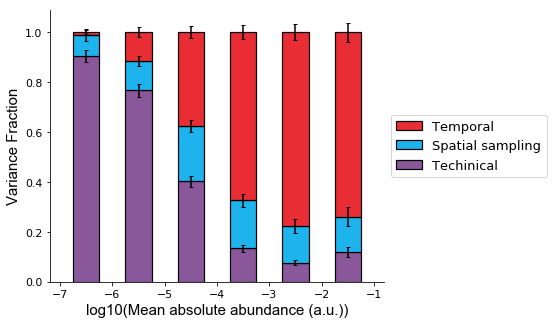

In [6]:
fig1, ax1 = plt.subplots(figsize=(6,5))
ax1.spines['top'].set_color('none')
ax1.spines['right'].set_color('none')
ax1.tick_params(axis='both', which='major', labelsize = 11)
plt.rcParams["errorbar.capsize"] = 2
ax1.set(xlim = (-7.2, -0.8))
width = 0.5

x_pos = [e + b_w / 2.0  for e in bins]

p1 = plt.bar(x_pos, array_means_var_fraction_N, width, 
             yerr = array_sem_var_fraction_N, color = "#8b579b", 
             linewidth = [1.2,] * len(bins), edgecolor = ["black",] * len(bins))

p2 = plt.bar(x_pos, array_means_var_fraction_S, width,
             bottom = array_means_var_fraction_N, yerr = array_sem_var_fraction_S, color = "#1eb3ec",
             linewidth = [1.2,] * len(bins), edgecolor = ["black",] * len(bins))

p3 = plt.bar(x_pos, array_means_var_fraction_T, width,
             bottom = array_means_var_fraction_N + array_means_var_fraction_S, 
             yerr = array_sem_var_fraction_T, color = "#e82d35",
             linewidth = [1.2,] * len(bins), edgecolor = ["black",] * len(bins))

plt.ylabel('Variance Fraction', fontsize = 15, fontname="Arial")
plt.xlabel('log10(Mean absolute abundance (a.u.))', fontsize = 15, fontname="Arial")
plt.legend((p3[0], p2[0], p1[0]), ('Temporal','Spatial sampling','Techinical'), 
           loc = "center left", bbox_to_anchor=(1, 0.5), fontsize = 13)
plt.show()


### load covariance/correlation decompostion result

In [7]:
with open(DIVERS_output_prefix + ".correlation_total.csv") as f:
    data_correlation_total = pd.read_csv(f, index_col=0, lineterminator = '\n')
with open(DIVERS_output_prefix + ".correlation_decomposition_temporal.csv") as f:
    data_correlation_decomposition_T = pd.read_csv(f, index_col=0, lineterminator = '\n')
with open(DIVERS_output_prefix + ".correlation_decomposition_spatial.csv") as f:
    data_correlation_decomposition_S = pd.read_csv(f, index_col=0, lineterminator = '\n')
with open(DIVERS_output_prefix + ".correlation_decomposition_technical.csv") as f:
    data_correlation_decomposition_N = pd.read_csv(f, index_col=0, lineterminator = '\n')

data_correlation_total.head()

,otu_1,otu_2,otu_3,otu_4,otu_5,otu_6,otu_7,otu_8,otu_9,otu_10,...,otu_284,otu_304,otu_315,otu_352,otu_370,otu_383,otu_388,otu_394,otu_416,otu_429
otu_1,0.999401,0.389493,0.647455,-0.259060,0.671129,0.459151,0.656477,0.584950,0.301842,0.683046,...,0.505472,0.756920,-0.119012,0.645025,0.260777,0.611329,-0.052955,0.367833,0.121635,-0.020088
otu_2,0.389493,1.006569,0.727293,0.374931,0.246965,0.849418,0.695874,0.102062,0.739680,-0.081591,...,0.434071,0.228078,0.485868,0.299968,-0.202302,0.256495,-0.239969,0.563858,0.505831,0.295317
otu_3,0.647455,0.727293,1.000754,0.139800,0.411750,0.806139,0.899056,0.401174,0.574122,0.395306,...,0.201362,0.551620,0.458346,0.412117,0.051613,0.335812,-0.199755,0.512535,0.235261,0.199344
otu_4,-0.259060,0.374931,0.139800,1.012161,-0.204133,0.327326,0.096202,-0.373251,0.386637,-0.440424,...,-0.153855,-0.267793,0.488640,-0.200030,-0.288030,-0.073999,-0.007998,0.052761,0.407035,0.310379
otu_5,0.671129,0.246965,0.411750,-0.204133,1.006044,0.242789,0.450349,0.447326,0.382297,0.686638,...,0.494257,0.886796,-0.184327,0.967871,0.480431,0.724716,-0.280701,0.382022,0.219779,-0.215898


### find OTUs with high abundance

In [8]:
if_abundance_10e4 = data_variance_decomposition["Average_abundances"] > 10 ** -4
index_abundance_10e4 = [i for i in range(len(if_abundance_10e4)) if if_abundance_10e4[i] == True]
otu_abundance_10e4 = data_variance_decomposition["OTU_ID"][index_abundance_10e4].values

data_variance_decomposition_highAbundance = data_variance_decomposition.loc[index_abundance_10e4,:]
data_correlation_total_highAbundance = data_correlation_total.loc[otu_abundance_10e4,otu_abundance_10e4]
data_correlation_decomposition_T_highAbundance = data_correlation_decomposition_T.loc[otu_abundance_10e4,otu_abundance_10e4]
data_correlation_decomposition_S_highAbundance = data_correlation_decomposition_S.loc[otu_abundance_10e4,otu_abundance_10e4]
data_correlation_decomposition_N_highAbundance = data_correlation_decomposition_N.loc[otu_abundance_10e4,otu_abundance_10e4]
df_taxonomy_highAbundance = df_taxonomy.loc[index_abundance_10e4,:]

### get pairwise correlations (total, temporal, spatial and technical)

In [9]:
triu_index_pair = []
triu_otu_pair = []
for i in range(len(otu_abundance_10e4)):
    for j in range(i + 1,len(otu_abundance_10e4)):
        triu_index_pair.append([i,j])
        triu_otu_pair.append([otu_abundance_10e4[i],otu_abundance_10e4[j]])

cors_total = [data_correlation_total_highAbundance.loc[e[0],e[1]] for e in triu_otu_pair]
cors_T = [data_correlation_decomposition_T_highAbundance.loc[e[0],e[1]] for e in triu_otu_pair]
cors_S = [data_correlation_decomposition_S_highAbundance.loc[e[0],e[1]] for e in triu_otu_pair]
cors_N = [data_correlation_decomposition_N_highAbundance.loc[e[0],e[1]] for e in triu_otu_pair]

### boxplot of pairwise correlations (total, temporal, spatial and technical)

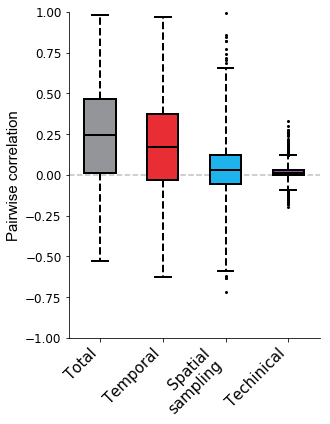

In [10]:
fig2, ax2 = plt.subplots(figsize=(4.5,6))
ax2.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.tick_params(axis='both', which='major', labelsize = 12)
ax2.set(ylim = (-1, 1))
for label in ax2.get_xmajorticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")
    label.set_fontsize(15)
    
color_list = ["#939598","#e82d35","#1eb3ec","#8b579b"]
flierprops = dict(marker='o', markerfacecolor='black', markersize = 2,
                  linestyle='none')
bp0 = plt.boxplot([cors_total, cors_T, cors_S, cors_N], flierprops = flierprops, patch_artist = True,
                  labels = ['Total','Temporal','Spatial\nsampling','Techinical'],
                  widths = 0.5, whis = 3)
for item in ['boxes', 'medians', 'caps']:
        plt.setp(bp0[item], color = "black", linewidth = 2, linestyle = "-")  
for item in ['whiskers']:
        plt.setp(bp0[item], color = "black", linewidth = 2, linestyle = "--")
for patch, color in zip(bp0['boxes'], color_list):
        patch.set_facecolor(color)

plt.axhline(y = 0, color = 'grey', linestyle='--', alpha = 0.5, linewidth = 1.5)
plt.ylabel('Pairwise correlation', fontsize = 15, fontname="Arial")
plt.show()

### Covariance decomposition by phyla
we will get indices for four dominant phyla and get correlations (total, temporal, spatial and technical) within and between phyla

In [11]:
phyla_inds = ["Actinobacteria", "Bacteroidetes", "Firmicutes", "Proteobacteria"]
otu_phyla = []
for each in phyla_inds:
    tmp_if = [e for e in df_taxonomy_highAbundance["phlum"] == each]
    tmp_index = [i for i in range(len(tmp_if)) if tmp_if[i] == True]
    tmp_otu = np.array(data_variance_decomposition_highAbundance["OTU_ID"])[tmp_index]
    otu_phyla.append(tmp_otu)

cors_phyla_total = np.zeros((len(phyla_inds), len(phyla_inds)))
cors_phyla_T = np.zeros((len(phyla_inds), len(phyla_inds)))
cors_phyla_S = np.zeros((len(phyla_inds), len(phyla_inds)))
cors_phyla_N = np.zeros((len(phyla_inds), len(phyla_inds)))

for i in range(len(phyla_inds)):
    for j in range(i,len(phyla_inds)):
        tmp_phyla_1 = phyla_inds[i]
        tmp_phyla_2 = phyla_inds[j]
        tmp_cors_total = data_correlation_total.loc[otu_phyla[i],otu_phyla[j]]
        tmp_cors_T = data_correlation_decomposition_T.loc[otu_phyla[i],otu_phyla[j]]
        tmp_cors_S = data_correlation_decomposition_S.loc[otu_phyla[i],otu_phyla[j]]
        tmp_cors_N = data_correlation_decomposition_N.loc[otu_phyla[i],otu_phyla[j]]
        
        if i == j:
            triu_otu_pair = []
            for p in range(len(otu_phyla[i])):
                for q in range(p + 1,len(otu_phyla[i])):
                    triu_otu_pair.append([otu_phyla[i][p],otu_phyla[i][q]])

            cors_phyla_total[i,j] = np.mean([tmp_cors_total.loc[e[0],e[1]] for e in triu_otu_pair])
            cors_phyla_T[i,j] = np.mean([tmp_cors_T.loc[e[0],e[1]] for e in triu_otu_pair])
            cors_phyla_S[i,j] = np.mean([tmp_cors_S.loc[e[0],e[1]] for e in triu_otu_pair])
            cors_phyla_N[i,j] = np.mean([tmp_cors_N.loc[e[0],e[1]] for e in triu_otu_pair])
        else:
            cors_phyla_total[i,j] = np.mean(np.mean(tmp_cors_total))
            cors_phyla_total[j,i] = np.mean(np.mean(tmp_cors_total))
            cors_phyla_T[i,j] = np.mean(np.mean(tmp_cors_T))
            cors_phyla_T[j,i] = np.mean(np.mean(tmp_cors_T))
            cors_phyla_S[i,j] = np.mean(np.mean(tmp_cors_S))
            cors_phyla_S[j,i] = np.mean(np.mean(tmp_cors_S))
            cors_phyla_N[i,j] = np.mean(np.mean(tmp_cors_N))
            cors_phyla_N[j,i] = np.mean(np.mean(tmp_cors_N))
            

### Heatmap of average total correlations within and between phyla

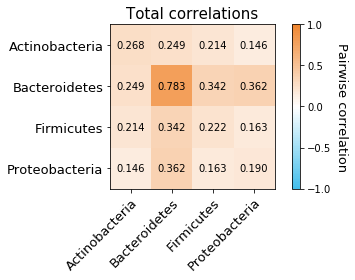

In [12]:
data_to_draw = cors_phyla_total

color_list = np.array(((68, 191, 236),  (255 ,255 ,255), (240, 135, 49))) / 255
cm = LinearSegmentedColormap.from_list("heatmapColor", color_list, N=100)
valfmt = StrMethodFormatter("{x:.3f}")

fig3, ax3 = plt.subplots()  
im = ax3.imshow(data_to_draw, interpolation = 'nearest', cmap = cm, vmin = -1, vmax = 1)
ax3.set_xticks(np.arange(len(phyla_inds)))
ax3.set_yticks(np.arange(len(phyla_inds)))
ax3.set_xticklabels(phyla_inds, fontsize = 13)
ax3.set_yticklabels(phyla_inds, fontsize = 13)
plt.setp(ax3.get_xticklabels(), rotation = 45, ha="right",
        rotation_mode = "anchor")
for i in range(len(phyla_inds)):
    for j in range(len(phyla_inds)):
        text = ax3.text(j, i, valfmt(data_to_draw[i, j]),
                        ha="center", va="center", color="black", fontsize = 10)        
for edge, spine in ax3.spines.items():
        spine.set_visible(True)
cbar = ax3.figure.colorbar(im, ax = ax3, ticks=[-1, -0.5, 0, 0.5, 1])
cbar.ax.set_ylabel("Pairwise correlation", rotation = -90, va="bottom", fontsize = 13)
ax3.set_title("Total correlations", fontsize = 15)
fig3.tight_layout()    
plt.show()

### Heatmap of average decomposed correlations (temporal, spatial and technical) within and between phyla

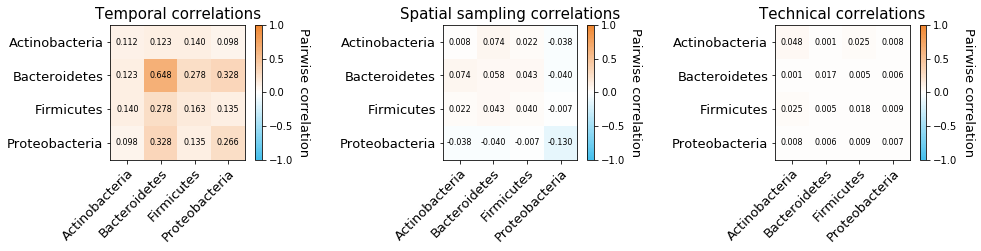

In [13]:
data_to_draw = [cors_phyla_T, cors_phyla_S, cors_phyla_N]
label_list = ["Temporal correlations", "Spatial sampling correlations","Technical correlations"]

color_list = np.array(((68, 191, 236),  (255 ,255 ,255), (240, 135, 49))) / 255
cm = LinearSegmentedColormap.from_list("heatmapColor", color_list, N=100)
valfmt = StrMethodFormatter("{x:.3f}")

fig4, ax4 = plt.subplots(1, 3, figsize=(14, 3.5))

for tmp_i, tmp_ax in enumerate(ax4):
    im = tmp_ax.imshow(data_to_draw[tmp_i], interpolation = 'nearest', cmap = cm, vmin = -1, vmax = 1)
    tmp_ax.set_xticks(np.arange(len(phyla_inds)))
    tmp_ax.set_yticks(np.arange(len(phyla_inds)))
    tmp_ax.set_xticklabels(phyla_inds, fontsize = 13)
    tmp_ax.set_yticklabels(phyla_inds, fontsize = 13)
    plt.setp(tmp_ax.get_xticklabels(), rotation = 45, ha="right",
             rotation_mode = "anchor")
    for i in range(len(phyla_inds)):
        for j in range(len(phyla_inds)):
            text = tmp_ax.text(j, i, valfmt(data_to_draw[tmp_i][i, j]),
                              ha="center", va="center", color="black", fontsize = 8)        
    for edge, spine in tmp_ax.spines.items():
            spine.set_visible(True)
    cbar = tmp_ax.figure.colorbar(im, ax = ax4[tmp_i], ticks=[-1, -0.5, 0, 0.5, 1])
    cbar.ax.set_ylabel("Pairwise correlation", rotation = -90, va="bottom", fontsize = 13)
    tmp_ax.set_title(label_list[tmp_i], fontsize = 15)

fig4.tight_layout()    
plt.show()